In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [18]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
#num_words restricts data to 10,000 most frequently occuring words found in data


**Data Overview**

This dataset contains shorts newswires with their topics as labels. Each newswire has a single topic label, hence this is a *single-label multiclass classification* problem. There are 46 topics, 8,982 training examples (newswires), and 2,246 test examples.

Each example is a list of integers which are word indeces from the set 0f 10,000 most common words in the data. 

Each label is an integer between 0 and 45 and represent a topic index.


In [10]:
train_labels[4], train_data[4]


(4,
 [1,
  8295,
  111,
  8,
  25,
  166,
  40,
  638,
  10,
  436,
  22,
  265,
  9,
  621,
  575,
  1080,
  4742,
  1149,
  2,
  6,
  438,
  8295,
  13,
  102,
  388,
  15,
  90,
  67,
  7,
  197,
  8295,
  8,
  4,
  270,
  416,
  23,
  527,
  6,
  2,
  4891,
  4,
  1055,
  742,
  16,
  8,
  36,
  1480,
  6,
  2124,
  100,
  543,
  5,
  645,
  362,
  6,
  2912,
  4,
  49,
  8,
  2,
  976,
  124,
  20,
  5,
  8295,
  80,
  9,
  100,
  362,
  543,
  395,
  61,
  44,
  20,
  8295,
  8,
  16,
  40,
  1276,
  42,
  1436,
  166,
  415,
  6,
  888,
  4,
  116,
  9,
  40,
  3089,
  4,
  303,
  163,
  16,
  64,
  772,
  13,
  94,
  156,
  17,
  12])

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join(
    [reverse_word_index.get(i-3, '?') for i in train_data[0]])


In [7]:
def decode_newswire(reverse_word_index, newswire_data, newswire_index):
    decoded_newswire = " ".join(
        [reverse_word_index.get(i-3, '?') for i in newswire_data[newswire_index]])
    return decoded_newswire


In [8]:
decode_newswire(reverse_word_index, train_data, 4)


'? seton co said its board has received a proposal from chairman and chief executive officer philip d ? to acquire seton for 15 75 dlrs per share in cash seton said the acquisition bid is subject to ? arranging the necessary financing it said he intends to ask other members of senior management to participate the company said ? owns 30 pct of seton stock and other management members another 7 5 pct seton said it has formed an independent board committee to consider the offer and has deferred the annual meeting it had scheduled for march 31 reuter 3'

In [12]:
def vectorize_sequences(sequences, dimension=10000):
    #sequences is an array of arrays. The internal array is a list of integers that map to a word that appears in the newswire.
    results = np.zeros((len(sequences), dimension)) #initializes an all-zero matrix of shape (len(sequences), dimension) 
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i,j] = 1. #period makes this integer a float
            #this iterates through integers in input array and treats them as indeces in the vectorized output. 
            #for each integer input, the corresponding vector index is encoded with a 1. The rest remain a 0.
    return results #an array of "vector" arrays


In [15]:
#vectorize newswire as a vector of 0s and 1s that indicate which word indeces are present
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [16]:
#convert labels via one-hot encoding / categorical encoding, in vectors with 0s for all categories and a 1 for the relevant category
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results


In [20]:
#vectorize training and test labels
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)


In [25]:
#can vectorize labels with built-in Keras functions as well:
from tensorflow.keras.utils import to_categorical
y_train_alt = to_categorical(train_labels)
y_test_alt = to_categorical(test_labels)

np.array_equal(y_train, y_train_alt), np.array_equal(y_test, y_test_alt)

(True, True)

**Model Architecture**

When a layer reduces the dimensionality of the inputs, information / complexity is lost. Since we are trying to classify newswire inputs into 46 labels, it is important to retain dimensionality. For this model we are using 64 unit layers. The final layer outputs a 46-dimensional vector, where each entry encodes a different class.

This model needs to return probabilities for 46 potential categories. Rather than using a sigmoid activation function at end, we use *softmax* activation. The model will output a probability distribution over the 46 different output classes, which means a 46-dimensional vector where each entry is the probability the sample (newswire) belongs to the class corresponding to that index. As this is a probability distribution, the 46 scores sum up to 1.

In the compile step, we will use rmsprop for the optimizer (standard, works well for most problems), track accuracy in metrics, and use *categorical_crossentropy* for loss. Categorical crossentropy measures the distance between two probability distributions: <br> 
<br>
    1) The probability distribution output by the model<br>
    2) The true probability distribution of the labels<br>
   <br>
By minimizing the distance between these two distributions, the model is trained to output something as close as possible to the true labels.


In [28]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [29]:
#next we set aside validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]


In [30]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Epoch 1/20
16/16 [==============================] - 1s 39ms/step - loss: 2.7243 - accuracy: 0.5103 - val_loss: 1.7643 - val_accuracy: 0.6570
Epoch 2/20
16/16 [==============================] - 0s 21ms/step - loss: 1.4394 - accuracy: 0.7164 - val_loss: 1.3331 - val_accuracy: 0.7170
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - loss: 1.0586 - accuracy: 0.7823 - val_loss: 1.1542 - val_accuracy: 0.7560
Epoch 4/20
16/16 [==============================] - 1s 33ms/step - loss: 0.8303 - accuracy: 0.8269 - val_loss: 1.0518 - val_accuracy: 0.7770
Epoch 5/20
16/16 [==============================] - 0s 27ms/step - loss: 0.6583 - accuracy: 0.8656 - val_loss: 0.9985 - val_accuracy: 0.7820
Epoch 6/20
16/16 [==============================] - 0s 27ms/step - loss: 0.5251 - accuracy: 0.8931 - val_loss: 0.9394 - val_accuracy: 0.8070
Epoch 7/20
16/16 [==============================] - 0s 26ms/step - loss: 0.4205 - accuracy: 0.9147 - val_loss: 0.9381 - val_accuracy: 0.8050
Epoch 8/20
16

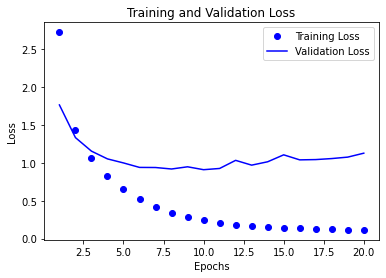

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


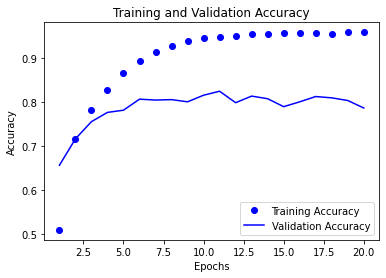

In [32]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


After ~8 or 9 epochs the model begins to overfit. So build a new one with 9 epochs:

In [38]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

results = model.evaluate(x_test, y_test)


Epoch 1/9
18/18 [==============================] - 1s 17ms/step - loss: 2.3167 - accuracy: 0.5495
Epoch 2/9
18/18 [==============================] - 0s 13ms/step - loss: 1.2642 - accuracy: 0.7287
Epoch 3/9
18/18 [==============================] - 0s 13ms/step - loss: 0.9422 - accuracy: 0.7960
Epoch 4/9
18/18 [==============================] - 0s 13ms/step - loss: 0.7352 - accuracy: 0.8441
Epoch 5/9
18/18 [==============================] - 0s 17ms/step - loss: 0.5766 - accuracy: 0.8801
Epoch 6/9
18/18 [==============================] - 0s 13ms/step - loss: 0.4601 - accuracy: 0.9025
Epoch 7/9
18/18 [==============================] - 0s 13ms/step - loss: 0.3659 - accuracy: 0.9184
Epoch 8/9
18/18 [==============================] - 0s 14ms/step - loss: 0.3061 - accuracy: 0.9301
Epoch 9/9
71/71 [==============================] - 0s 1ms/step - loss: 0.9797 - accuracy: 0.7858


In [39]:
print('Test set accuracy: ' + str(results[1]))
print('Test set loss: ' + str(results[0]))


Test set accuracy: 0.7858415246009827
Test set loss: 0.9796842336654663


**Evaluating Model Accuracy**

In a balanced binary classification problem, we expect the accuracy by a purely random classifier to be 50%. But with 46 classes, we need to create a random classifier to see what our baseline accuracy would be in this situation.

The below cell does this, and we see that, with random assignment / classification, we expect a test accuracy of ~18.5%. With this in mind, our model's test accuracy of ~78.6% looks pretty good.


In [41]:
import copy
test_labels_copy = copy.copy(test_labels) #creates copy of labels array
np.random.shuffle(test_labels_copy) #shuffles the labels in the array, simulates random assignment / classification
hits_array = np.array(test_labels) == np.array(test_labels_copy) #creates an array with 0s when true and random 
#assignments are unequal and 1s where they are
hits_array.mean() #simulates random accuracy, adds up all the times it accuractely categorized and divides by the total number 
#of samples


0.18477292965271594

**Predictions on Test Data**

Using the model's predict method returns a class probability distribution across all 46 topics for each sample. Can assign a label by choosing the index of the max value.


In [43]:
predictions = model.predict(x_test)
predictions[0].shape, np.sum(predictions[0])


71/71 [==============================] - 0s 1ms/step


((46,), 1.0)

In [47]:
predicted_classes = np.zeros((len(x_test), 1))
for index, preds in enumerate(predictions):
    label = np.argmax(preds)
    predicted_classes[index] = label
predicted_classes


array([[ 4.],
       [ 1.],
       [ 1.],
       ...,
       [ 3.],
       [ 4.],
       [24.]])

**Alternate Handling of Labels & Loss**

Can also encode labels as an integer tensor, as in an array with integer labels rather than an array of vectors that one-hot code the category. 

The only change this would impose is changing the loss function from categorical crossentropy to *sparse categorical crossentropy*.

y_train = np.array(train_labels)
y_test = np.array(test_labels)

model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
